# Reset networks - number topography
**Objective**

Demonstrate the emergence of topography for numbers in Reset networks.

**Means**

Reset network <br>
Number codes as distributed labels (random matrix theory) <br>

<img src = 'https://github.com/THANNAGA/Reset-Networks/blob/main/Topography%20for%20numbers/Reset_general_specific_approach.png?raw=true' width=700px>


*Figure 1.(A) Reset Networks approach the visual cortex as a sequence of levels that realize different topographic spaces. Each level consists in a grid of deep neural networks shares the entire input from the level below. The output of the grid then becomes the input to the grid of networks at the next level.**(B)** A depth 2 Reset network as a model of parietal cortex. When trained to map number images onto developmentally realistic number codes, topography for numbers appears at level 1 of the network.*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from PIL import Image
import time
import numpy as np
from numpy.ma import masked_array
from scipy import ndimage
from scipy.signal import convolve2d as conv
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import sys, math
import pandas as pd
from sklearn.utils import shuffle
import cv2

sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/')
from resnet import resnetSmall, resnet18, resnet34, resnet50, resnet101, resnet152 
from resnet_CIFAR10 import resnet20, hresnet20reg

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelname = 'ResetNumber8'#'ResNet20'#'ResetNumber8'
dataset = 'Numbers10'
train_batchsize = 100
test_batchsize = 100
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
use_cuda = True
gridsize = 4
n_classes1 = 8*8#4*4#16*16#8*8#32*32#400#36#100
n_classes = 100
lrate = 0.001
drop_rate = 0.5
input_channels = 3
load_model = False
load_submodels = False
epochs = 50

Transforms for data augmentation

In [ ]:
augment_data = False
if augment_data: 
    transform = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    
    transform_w = transforms.Compose(
      [transforms.RandomCrop(32, padding=4),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize((0, 0, 0), (1, 1, 1))])
else: 
    transform = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))])
    transform_w = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0, 0, 0), (1, 1, 1))])

# Creating the number dataset (skip if already loaded)

Create number dataset: 
X = images in 3 x 32 x 32 format<br>
Y = number codes - [Hannagan et al. (2018)](https://royalsocietypublishing.org/doi/10.1098/rstb.2017.0253)<br>

In [ ]:
from PIL import Image, ImageDraw, ImageFont, ImageFile
def numbers_to_images(shuffle=True, text=None, numex=1, dimx = 32, dimy = 32, size=8, show=False):
    nw_array = np.zeros((6*12*9, 3, dimx, dimy))   #6x, 24y, 9fonts
    fontnames = ['arial', 'lato', 'openSans', 'ostrich', 'oswald', 'PTN57F', 'raleway', 'roboto', 'tahoma']
    i = 0
    for xshift in np.arange(-3,3):
      for yshift in np.arange(-6,6):
        for fontname in fontnames:
          if len(text) == 1:
            size = np.random.randint(15,20)

          text = text.upper()

          img = Image.new("RGB", (dimx,dimy), color = (255, 255, 255))
          fnt = ImageFont.truetype(checkpointpath+fontname+'.ttf', size) #size in pixels
          draw = ImageDraw.Draw(img)
          w, h = fnt.getsize(text)
          draw.text((xshift + (dimx-w)/2, yshift + (dimy-h)/2), text, font=fnt, fill='black')

          if show:
              print ('was here')
              plt.imshow(img);plt.show()
          nw_array[i] = np.moveaxis(np.array(img), 2, 0)
          if np.mean(nw_array[i]) == 255.0:
            print ('xshift, yshift, text, fontname', xshift, yshift, text, fontname)
            return 'issue'
          i += 1

    if shuffle:
      np.random.shuffle(nw_array)
    return nw_array[:numex]

def numbers_to_vectors(number_codes=None, number_id=0, numex=1):
    number_vector = number_codes[number_id, 0]
    number_vectors = np.repeat(np.expand_dims(number_vector, axis=0), numex, axis=0)
    return number_vectors

def numbers_to_labels(number_id=0, numex=1):
    number_vector = number_codes[number_id, 0]
    number_labels = number_id*np.ones(numex)
    return number_labels

In [ ]:
number_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
np.save(checkpointpath + "number_classes.npy", number_list)

#number_codes = np.load(checkpointpath + "Numbers_num40_dim100.npy")
number_codes = np.load(checkpointpath + "Numbers_stable.npy");number_codes = np.expand_dims(number_codes, axis=1)
print ('number_codes.shape', number_codes.shape)
def create_number_dataset(dimx=32, dimy=32, dimn=100, number_list=None, numex=600):
  
  n = len(number_list)
  num_train = 500
  num_test = 100

  X_train = np.zeros((n*num_train, 3, dimx, dimy))
  Y1_train = np.zeros((n*num_train, dimn))
  Y2_train = np.zeros(n*num_train)

  X_test = np.zeros((n*num_test, 3, dimx, dimy))
  Y1_test = np.zeros((n*num_test, dimn))
  Y2_test = np.zeros(n*num_test)


  # Calculate input image and p_vector
  for i, number in enumerate(number_list):
    number_matrices = numbers_to_images(text=number, size=10, numex=numex)
    number_vectors = numbers_to_vectors(number_codes = number_codes, number_id=i, numex=numex)
    number_labels = numbers_to_labels(number_id=i, numex=numex)
    
    X_train[i*num_train : (i+1)*num_train] = number_matrices[:num_train]
    Y1_train[i*num_train : (i+1)*num_train] = number_vectors[:num_train]
    Y2_train[i*num_train : (i+1)*num_train] = number_labels[:num_train]

    X_test[i*num_test : (i+1)*num_test] = number_matrices[-num_test:]
    Y1_test[i*num_test : (i+1)*num_test]= number_vectors[-num_test:]
    Y2_test[i*num_test : (i+1)*num_test] = number_labels[:num_test]
  
  # print shapes
  print ('X_train.shape', X_train.shape)
  print ('Y1_train.shape', Y1_train.shape)
  print ('Y2_train.shape', Y2_train.shape)

  print ('X_test.shape', X_test.shape)
  print ('Y1_test.shape', Y1_test.shape)
  print ('Y2_test.shape', Y2_test.shape)

  # save datasets
  np.save(checkpointpath + "number_images_train.npy", X_train)
  np.save(checkpointpath + "number_codes_train.npy", Y1_train)
  np.save(checkpointpath + "number_labels_train.npy", Y2_train)

  np.save(checkpointpath + "number_images_test.npy", X_test)
  np.save(checkpointpath + "number_codes_test.npy", Y1_test)  
  np.save(checkpointpath + "number_labels_test.npy", Y2_test)
  
  return X_train, Y1_train, Y2_train, X_test, Y1_test, Y2_test

create_sym_dataset = False
if create_sym_dataset:
  X_train, Y1_train, Y2_train, X_test, Y1_test, Y2_test = create_number_dataset(number_list=number_list, numex=1100)

number_codes.shape (21, 1, 100)


Load dataset: Numbers 10 - custom loading

In [ ]:
from torch.utils.data import Dataset
class SymbolDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
        if self.transform:
          #sample = Image.fromarray(self.X[index])
          #sample = self.transform(sample)
          sample = self.transform(self.X[index])
          x = torch.tensor(sample).float()
        else:
          x = torch.tensor(self.X[index]).float()
        #custom item-wise standaradizing
        #mu = torch.mean(x, dim = (1,2), keepdim = True)
        #sd = torch.std(x, dim = (1,2), keepdim = True)
        #x = (x - mu)/sd
        #x = 1-x
        y = torch.tensor(self.Y[index]).float()

        return (x/255.0, y)

class SymbolDataset2(Dataset):
    def __init__(self, X, Y1, Y2, transform=None):
        self.X = X
        self.Y1 = Y1
        self.Y2 = Y2
        self.transform = transform

    def __len__(self):
        return len(self.Y2)

    def __getitem__(self, index):
        if self.transform:
          #sample = Image.fromarray(self.X[index])
          #sample = self.transform(sample)
          sample = self.transform(self.X[index])
          x = torch.tensor(sample).float()
        else:
          x = torch.tensor(self.X[index]).float()
        #custom item-wise standaradizing
        #mu = torch.mean(x, dim = (1,2), keepdim = True)
        #sd = torch.std(x, dim = (1,2), keepdim = True)
        #x = (x - mu)/sd
        #x = 1-x
        y1 = torch.tensor(self.Y1[index]).float()
        y2 = torch.tensor(self.Y2[index]).float()

        return (x/255.0, y1, y2)


train_x = np.load(checkpointpath + "number_images_train.npy")
train_y1 = np.load(checkpointpath + "number_codes_train.npy")
train_y2 = np.load(checkpointpath + "number_labels_train.npy")

test_x = np.load(checkpointpath + "number_images_test.npy")
test_y1 = np.load(checkpointpath + "number_codes_test.npy")
test_y2 = np.load(checkpointpath + "number_labels_test.npy")

classes = np.load(checkpointpath + "number_classes.npy")
print ('train_x.shape', train_x.shape)
print ('test_x.shape', test_x.shape)
train_y1 = np.array(train_y1)
test_y1 = np.array(test_y1)
train_y2 = np.array(train_y2, dtype='int')
test_y2 = np.array(test_y2, dtype='int')

if augment_data: 
  #train_x = np.moveaxis(train_x, 1, 3); test_x = np.moveaxis(test_x, 1, 3)
  train_x = np.array(train_x, dtype = 'uint')
  test_x = np.array(test_x, dtype = 'uint')
  print ('np.shape(train_x)', np.shape(train_x))
  print ('np.min(train_x)', np.min(train_x))
  print ('np.max(train_x)', np.max(train_x))

trainset = SymbolDataset(train_x, train_y1)#, transform=transform_w)
testset = SymbolDataset(test_x, test_y1)
trainset2 = SymbolDataset2(train_x, train_y1, train_y2)#, transform=transform_w)
testset2 = SymbolDataset2(test_x, test_y1, test_y2)

train_x.shape (5000, 3, 32, 32)
test_x.shape (1000, 3, 32, 32)


Dataloaders

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batchsize, shuffle=True, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batchsize, shuffle=False, num_workers=1)

lc = len(classes)

class_total = np.zeros(lc)
for ex in trainset2:
  class_total[int(ex[2])] += 1
weights = torch.Tensor(np.max(class_total)/np.array(class_total)).float()
print ('number of classes:', len(weights))
print ('weights.size():', weights.size())
print ('weights:', weights)
print ('Custom number dataset has been loaded')

number of classes: 10
weights.size(): torch.Size([10])
weights: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Custom number dataset has been loaded


Reality check

classes[index], mean: 7 0.96922493
classes[index], mean: 2 0.9645872
classes[index], mean: 7 0.97526425
classes[index], mean: 5 0.9620711
classes[index], mean: 1 0.9763174


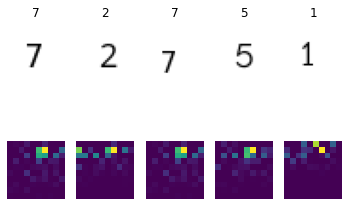

codes[0] tensor([0.0000e+00, 1.4549e-02, 0.0000e+00, 6.4039e-02, 0.0000e+00, 0.0000e+00,
        8.7235e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.2763e-02, 0.0000e+00, 0.0000e+00, 6.8468e-01, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.2728e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8524e-01,
        0.0000e+00, 6.1496e-01, 5.7063e-01, 0.0000e+00, 3.4843e-01, 8.1785e-02,
        0.0000e+00, 7.7252e-02, 0.0000e+00, 1.5576e-02, 0.0000e+00, 1.9266e-01,
        0.0000e+00, 6.6046e-02, 5.8720e-02, 0.0000e+00, 0.0000e+00, 1.1174e-02,
        1.1362e-02, 0.0000e+00, 2.0503e-02, 2.7426e-02, 4.2481e-02, 0.0000e+00,
        3.4780e-02, 0.0000e+00, 2.1972e-02, 0.0000e+00, 0.0000e+00, 1.3141e-01,
        0.0000e+00, 0.0000e+00, 6.4699e-02, 0.0000e+00, 5.4347e-02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.4207e-02, 2.4674e-02,
        5.0919e-02, 6.7668e-03, 0.0000e+00, 6.3051e-02, 6.2625e-03, 2.7291e-02,
        0.0000e+00, 0.0000e+00,

In [ ]:
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=train_batchsize, shuffle=True, num_workers=1)
testloader2 = torch.utils.data.DataLoader(testset2, batch_size=test_batchsize, shuffle=False, num_workers=1)
train_iter = iter(trainloader2)
images, codes, labels = train_iter.next()
for i in np.arange(5):
  index = int(labels[i].numpy())
  plt.subplot(2,5,i+1)
  plt.title(classes[index])
  plt.axis('off')
  im = np.moveaxis(images[i].numpy(), 0,2)
  plt.imshow(im)
  plt.subplot(2,5,5+i+1)
  im2 = np.reshape(codes[i], (10, 10))
  plt.imshow(im2)
  plt.axis('off')
  print ('classes[index], mean:', classes[index], np.mean(im))
plt.savefig('Symbols_10.png', dpi = 300)
plt.show()
print ('codes[0]', codes[0])

## Model

In [ ]:
# Nested classifiers for CIFAR
class NestedCifarNoDecoder(nn.Module):
  def __init__(self, input_channels=3, h1_1=400, gridsize=8, n_classes1=16, n_classes2=10, drop_rate=0.2):
    super(NestedCifarNoDecoder, self).__init__()
    self.gridsize = gridsize
    self.n_classes1 = n_classes1
    self.sqrt_n_classes1 = int(n_classes1**0.5)
    self.Nest1 = nn.ModuleList([resnet20(num_channels=input_channels, num_classes=n_classes1) for i in np.arange(self.gridsize**2)])
    self.Classifier = resnet20(num_channels=1, num_classes=n_classes2)
    self.BN0 = nn.BatchNorm2d(num_features = 1)
    self.dropout = nn.Dropout(drop_rate)
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()
	
  def forward(self, x):
    level1 = [self.Nest1[i](x) for i in np.arange(self.gridsize**2)] #process input through all networks at level 1
    level1 = torch.stack(level1, dim=0)
    level1 = level1.permute(1,2,0)
    # reshape by patch (nested list comprehension probably more elegant)
    to_cat = []
    for j in np.arange(self.gridsize):
      to_cat += [torch.cat([level1[:,:,i].reshape(-1, 1, self.sqrt_n_classes1, self.sqrt_n_classes1) for i in np.arange(j*self.gridsize, (j+1)*self.gridsize)],3)]
    grid = torch.cat(to_cat, 2)
    #grid = self.sigmoid(grid)
    grid = self.tanh(grid)
    grid = self.dropout(grid)
    grid = self.BN0(grid)
    out_c = self.Classifier(grid)
    out_c = self.sigmoid(out_c)
    return grid, out_c

In [ ]:
def load_Model(checkpointpath=None, modelname=None, dataset=None, load_model=False,
               input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes):


  if 'NestedCifar' in modelname:
    net = NestedCifar(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Nested cortical networks for CIFAR loaded')

  if 'ResetNumber' in modelname:
    net = NestedCifarNoDecoder(input_channels=input_channels, gridsize=gridsize, n_classes1=n_classes1, n_classes2=n_classes)
    print ('Nested cortical networks (without autoencoder) for Numbers loaded')

  if 'ResNet20' in modelname:
    net = hresnet20reg(num_channels=input_channels, num_classes=n_classes)
    print ('ResNet20 loaded')

  model_total_params = sum(p.numel() for p in net.parameters())
  print('==> Model built. The model has ',model_total_params,'total parameters, and ',n_classes,'classes')

  if load_model:
    #load the model
    state = torch.load(checkpointpath + modelname + dataset + 'best_ckpt.t7')
    keys = list(state['net'].keys()); print ('This network had', len(keys),'stored sets of parameters')
    if 'module.' in keys[0]:
      for name in keys:
        state['net'][name[7:]] = state['net'].pop(name)
    net.load_state_dict(state['net'])
    print ('Pretrained weights loaded')

  if load_submodels:
    #load pretrained submodel
    pretrained_dict = submodel.state_dict()
    
    model_dict = model.state_dict()
    # 1. filter out unnecessary keys (remove key for last dense layer)
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k is not 'fc2'}
    # 2. overwrite entries in the existing state dict
    model_dict.update(pretrained_dict) 
    # 3. load the new state dict
    model.load_state_dict(pretrained_dict)
  
  return net

net = load_Model(checkpointpath=checkpointpath, modelname=modelname, load_model=load_model)

Nested cortical networks (without autoencoder) for Numbers loaded
==> Model built. The model has  4646998 total parameters, and  100 classes


# Training

Parallel computing

In [ ]:
# Parallel computing
device = torch.device("cuda" if use_cuda else "cpu")
print ('device:', device)
net.to(device)
net = torch.nn.DataParallel(net)
weights = weights.to(device)
GPUcount = torch.cuda.device_count()
if GPUcount == 0:
  print ('No GPU available.')
if GPUcount == 1:
  print ('One GPU available.')
if GPUcount > 1:
  print (GPUcount, 'GPUs are available.')
print ('GPU type:', torch.cuda.get_device_name())

device: cuda
One GPU available.
GPU type: Tesla P100-PCIE-16GB


In [ ]:
Adam=False
if Adam:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters(), lr=lrate)

In [ ]:
Sgd=False
if Sgd:
  criterion = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.SGD(net.parameters(), lr=lrate, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
BCE = True
if BCE:# Define an optimizer and criterion for autoencoder
  criterion = nn.BCELoss()
  optimizer = optim.Adam(net.parameters())

In [ ]:
CombinedLoss = False
if CombinedLoss:# Define an optimizer and criterion for autoencoder and classfier
  criterionAuto = nn.BCELoss()
  criterionClass = nn.CrossEntropyLoss(weight=weights)
  optimizer = optim.Adam(net.parameters())

Testing:

In [ ]:
def test2(net):
  net.eval()
  start = time.time()
  net.to(device)
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          inputs, codes = data
          inputs, codes = inputs.to(device), codes.to(device)
          grid, outputs = net(inputs)
          mse = torch.mean(torch.square(outputs - codes)).item()
          total += labels.size(0)

  print('Mse of the network on ',total,'test images:',mse)

  end = time.time()
  print('Test time:', time.strftime('%H:%M:%S', time.gmtime(end-start)))
  print('n')

  return grid, mse

Compute grid responses and output accuracies for all categories

In [ ]:
def compute_class_grid2(grid, verbose=False):
  n = len(classes)
  if modelname == 'ResNet20':
    gn, gh = grid.shape
    gc = 1
    gs = int(gh**0.5)
  else:
    gn, gc, gs, gs = grid.shape
  print ('gn, gc, gs, gs', gn, gc, gs, gs)
  class_correct = list(0. for i in np.arange(n))
  class_total = list(0. for i in np.arange(n))
  class_grid = np.zeros((n, gs, gs))
  with torch.no_grad():
      for data in testloader2:
          images, codes, labels = data
          #images, codes, labels = images.to(device), codes.to(device), labels.to(device)
          images, codes = images.to(device), codes.to(device)

          grid, outputs = net(images)
          mse = torch.mean(torch.square(outputs - codes), 1)
          grid_data = grid.cpu().numpy().squeeze()
          if modelname == 'ResNet20':
            grid_data = np.reshape(grid_data, (-1, gs, gs))

          for i, label in enumerate(labels):
              label = int(label.cpu().numpy())
              if gc > 1:
                class_grid[label] += np.mean(grid[i], axis=0)
              else:
                class_grid[label] += grid_data[i]
              class_correct[label] += mse[i].item()
              class_total[label] += 1
  class_acc = np.zeros(n)
  for i in np.arange(n):
      class_acc[i] = 100 * class_correct[i] / class_total[i]
      if class_total[i] > 0:
        class_grid[i] = class_grid[i]/class_total[i]
      if verbose:
        print('%3d Accuracy of %5s : %2d %% (%5d / %5d)' % (i, classes[i], class_acc[i], class_correct[i], class_total[i]))
  return class_acc, class_grid
  
go_compute_class_grid2 = False
if go_compute_class_grid2:
  class_acc, class_grid = compute_class_grid2(grid, verbose=True)

Training

In [ ]:
start = time.time()
e_start = time.time()
ltrain, ltest = len(trainloader), len(testloader)
print ('number of mini-batches for training:', ltrain)
print ('mini-batch size:', train_batchsize)
print ('total number of training exemplars:', ltrain*train_batchsize)
print ('\nnumber of mini-batches for testing:', ltest)
print ('mini-batch size:', test_batchsize)

if load_model:
  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')
  last_epoch = len(test_acc_history)
  bestacc = np.max(test_acc_history)
  print ('saved metrics loaded')
else:
  test_acc_history = []
  class_acc_history = []
  class_grid_history = []
  last_epoch = 0
  bestacc = 0

test_every = ltrain//2
#test_every = 2*ltrain   #never test
print_every = ltrain//20
print ('we will test every:', test_every, 'mini-batches, meaning, every',test_every*train_batchsize,'training exemplars.')

# Initial testing before training.
grid, testacc = test2(net)
test_acc_history += [testacc]
class_acc, class_grid = compute_class_grid2(grid, verbose=False)
class_acc_history += [class_acc]
class_grid_history += [class_grid]
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)

# Start training
net.train()
for epoch in np.arange(last_epoch + epochs): 
    print ('Epoch:', epoch) 
    running_loss = 0.0
    running_lossAuto = 0.0
    running_lossClass = 0.0
    for i, (inputs, codes, labels) in enumerate(trainloader2):
        inputs, codes = inputs.to(device), codes.to(device)
        #print ('labels.size()', labels.size())

        optimizer.zero_grad()
        grid, outputs = net(inputs)
        #print(outputs.size())
        loss = criterion(outputs, codes)

        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i != 0) & (i % print_every == 0):    # print
          print ('[batch %3d] number code loss:%.3f' % (i, loss.item()))

        if (i != 0) & (i % test_every == 0):    # test 
            e_end = time.time()
            print('\n\nTraining time:', time.strftime('%H:%M:%S', time.gmtime(e_end - e_start)))
            e_start = time.time()

            closs = running_loss / test_every
            print('[%d, %5d] number code loss:%.3f' % (epoch + 1, i + 1, closs))

            running_loss = 0.0
            _, testacc = test2(net)
            test_acc_history += [testacc]
            class_acc, class_grid = compute_class_grid2(grid, verbose=False)
            class_acc_history += [class_acc]
            class_grid_history += [class_grid]
            np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
            np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
            net.train()

            if testacc > bestacc:
              print ('saving as best model')
              state = {'net': net.state_dict(),}
              torch.save(state, checkpointpath + modelname + dataset + 'best_ckpt.t7')
              bestacc = testacc
np.save(checkpointpath + modelname + dataset + 'test_acc_history.npy', test_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_acc_history.npy', class_acc_history)
np.save(checkpointpath + modelname + dataset + 'class_grid_history.npy', class_grid_history)
end = time.time()
print('Done training. Total training time:')
print(time.strftime('%H:%M:%S', time.gmtime(end-start)))

NameError: ignored

## Number topography

In [ ]:
import math

def topo(data):
  #topo_index = np.mean(ndimage.sobel(data)) # the more variations on the sobeled map, the less the neighbors are the same, the less topography.
  #topo_index = np.mean(data - gaussian_filter(data, sigma = 1))
  filter = (-1/8)*np.ones((3, 3));filter[0,0]=1
  d = np.mean(ndimage.convolve(data, filter))
  dz = np.mean(ndimage.convolve(data, (1/8)*np.ones((3, 3))))
  if d != 0:
    topo_index = 1/d # topography == same neighbors ==> more canceling ==> low mean ==> high inverse of mean
  else:
    topo_index = dz
  return topo_index

def topo2(data):
  data = data.astype('float')
  n,n = data.shape
  topo_index, c = 0, 0
  for i in range(1, n-1):
    for j in range(1, n-1):
      if data[i, j] != -1:
        context = np.copy(data[i-1:i+2, j-1:j+2])
        mask = context == -1
        context[mask] = np.nan; context[1,1] = np.nan
        context = np.abs(context - data[i, j])
        context[mask] = 10; context[1,1] = np.nan
        #topo_index += 10 - np.nanmean(context)
        topo_index += 10 - np.nansum(context)/8
        c += 1
  if c != 0:
    topo_index = 0.1*topo_index/float(c)
    return topo_index
  if c == 0:
    return 0

def clustering_index2(data, threshold=0.85, connectivity=4):
  den_index = np.sum(data)
  data = (data > threshold).astype(np.uint8)
  # Thresholding
  ret, thresh = cv2.threshold(data,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
  # Choose 4 or 8 for connectivity type
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
  clu_index = np.mean(stats[1:,-1])
  if math.isnan(clu_index):
    clu_index = 1 #minimal cluster size
  
  return num_labels, labels, clu_index 

def compute_pipeline2(select1, select2, T = 1, connectivity = 8, gf_sigma=0, show=False):

  # compute d-prime sensitivity measure at each point of the grid
  mean1 = np.mean(select1, axis=0)
  mean2 = np.mean(select2, axis=0)
  std1 = np.var(select1, axis=0)**0.5
  std2 = np.var(select2, axis=0)**0.5

  # possibly smooth activations
  gf_sigma = 0#.5
  smean1 = gaussian_filter(mean1, sigma = gf_sigma)   # smoothing
  smean2 = gaussian_filter(mean2, sigma = gf_sigma)   

  # compute d-prime map
  dmap = 2*(smean1 - smean2)/(std1 + std2)

  # compute clustering index
  _, _, clu_index = clustering_index2(dmap, threshold=T, connectivity=connectivity)

  # compute control clustering index
  clu_index_ctrl = 0
  power = 20
  for k in range(10):
    dmapshuf = np.ravel(np.copy(dmap))
    np.random.shuffle(dmapshuf)
    dmapshuf = np.reshape(dmapshuf, dmap.shape)
    _, _, ctrl_clu = clustering_index2(dmapshuf, threshold=T, connectivity=connectivity)
    clu_index_ctrl += ctrl_clu
    
  clu_index_ctrl = clu_index_ctrl/float(power)

  # return variables
  targets_data = dmap #> T

  density = np.sum(smean1)
  if show:
    plt.figure(figsize=(10,10))
    plt.subplot(141);plt.imshow(mean1);plt.title('mean1');plt.axis('off')
    plt.subplot(142);plt.imshow(mean2);plt.title('mean2');plt.axis('off')
    plt.subplot(143);plt.imshow(dmap);plt.title('dprimes 1-2');plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.subplot(144);plt.imshow(dmap>T);plt.title('clustering:'+str(clu_index)[:5]);plt.axis('off');plt.colorbar(orientation='horizontal')
    plt.show()
    return stop_error
  
  return targets_data, clu_index, clu_index_ctrl

def compute_save_metrics2(modelname=None, dataset=None, T=2, S=0, nopref=False, n_epochs=21):
  # load data history
  class_acc_history = np.load(checkpointpath + modelname + dataset + 'class_acc_history.npy')[:n_epochs]
  print ('class_acc_history.shape',class_acc_history.shape)
  class_grid_history = np.load(checkpointpath + modelname + dataset + 'class_grid_history.npy')[:n_epochs]
  print ('class_grid_history.shape',class_grid_history.shape)

  # initialize arrays 
  _,_,x,y = np.shape(class_grid_history)
  n_classes = lc
  print ('n_epochs,n_classes,x,y', n_epochs,n_classes,x,y)
  target_maps_history = np.zeros((n_epochs, n_classes, x, y))
  clustering_history = np.zeros((n_epochs, n_classes))
  clustering_history_ctrl = np.zeros((n_epochs, n_classes))
  topo_history = np.zeros(n_epochs)
  topo_history_ctrl = np.zeros(n_epochs)
  target_acc_history = np.zeros((n_epochs, n_classes))

  # setting parameters for sensitivity and clustering analysis
  connectivity = 4

  # list of contrasts
  sets1 = np.arange(lc)
  sets2 = np.array([[j for j in sets1 if i != j] for i in sets1])
  
  # compute
  for epoch in range(n_epochs):
    print ('analyzing data from epoch', epoch)
    for cat, (set1, set2) in enumerate(zip(sets1, sets2)):
      #print ('cat', cat)
      #print ('set1', set1)
      #print ('set2', set2)
      select1 = class_grid_history[epoch, set1]
      select1 = np.expand_dims(select1, axis=0) #easier to expand dim here this way, for clustering index.
      select2 = class_grid_history[epoch, set2]
      
      targets_data, clustering, clustering_ctrl = compute_pipeline2(select1, select2, T = T, connectivity = connectivity, gf_sigma=S, show=False)
      target_maps_history[epoch, cat] = targets_data
      clustering_history[epoch, cat] = clustering
      clustering_history_ctrl[epoch, cat] = clustering_ctrl
      target_acc_history[epoch, cat] = np.mean(class_acc_history[epoch,set1])

  # create label maps. This makes a lot of sense for numerosity, since we've got a clear number line.
  
  if nopref:
    # label -1 will stand for "no preference", when all d-primes are below thresholds
    # we achieve that by concatenating a no preference map before the d-prime maps, filled with a high value.
    # then we remove 1 to all the labels.
    label_maps_history = np.zeros((n_epochs,x,y))
    for epoch, target_maps in enumerate(target_maps_history):
      thres_data = (target_maps<T)
      indices_no_pref = (np.sum(thres_data, axis=0) == lc)
      no_pref = 100*indices_no_pref
      no_pref = np.expand_dims(no_pref, axis=0)
      target_maps = np.concatenate((no_pref, target_maps))
      label_maps = np.argmax(target_maps, axis=0) - 1
      label_maps_history[epoch] = label_maps

      # Based on these preference maps, compute the topographic index at each epoch
      topo = topo2(label_maps)
      topo_history[epoch] = topo
      n_shufflings = 20
      topo_ctrl = 0
      for p in range(n_shufflings):
        #shuffle map
        dmapshuf = np.ravel(np.copy(label_maps))
        np.random.shuffle(dmapshuf)
        dmapshuf = np.reshape(dmapshuf, label_maps.shape)
        #compute topo for shuffled map
        topo_iter = topo2(dmapshuf)
        topo_ctrl += topo_iter
      topo_history_ctrl[epoch] = topo_ctrl/n_shufflings

    masked_array(label_maps_history, label_maps_history < 0)

    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)
    np.save(checkpointpath + modelname + dataset + 'topo_history.npy', topo_history)
    np.save(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy', topo_history_ctrl)

  else:
    label_maps_history = np.argmax(target_maps_history, axis=1)
    
    #save
    np.save(checkpointpath + modelname + dataset + 'target_acc_history.npy', target_acc_history)
    np.save(checkpointpath + modelname + dataset + 'target_maps_history.npy', target_maps_history) 
    np.save(checkpointpath + modelname + dataset + 'label_maps_history.npy', label_maps_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history.npy', clustering_history)
    np.save(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy', clustering_history_ctrl)
    np.save(checkpointpath + modelname + dataset + 'topo_history.npy', topo_history)
    np.save(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy', topo_history_ctrl)

In [ ]:
def animate_numerosity(T=None, S_map = None, save=True, nopref=False):
  import numpy as np
  from numpy.ma import masked_array
  import matplotlib.pyplot as plt
  from matplotlib import animation, rc
  from IPython.display import HTML
  from scipy.stats import describe

  test_acc_history = np.load(checkpointpath + modelname + dataset + 'test_acc_history.npy')
  target_acc_history = np.load(checkpointpath + modelname + dataset + 'target_acc_history.npy')
  clustering_history = np.load(checkpointpath + modelname + dataset + 'clustering_history.npy')
  clustering_history_ctrl = np.load(checkpointpath + modelname + dataset + 'clustering_history_ctrl.npy')
  topo_history = np.load(checkpointpath + modelname + dataset + 'topo_history.npy')
  topo_history_ctrl = np.load(checkpointpath + modelname + dataset + 'topo_history_ctrl.npy')
  if nopref:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history_nopref.npy')
  else:
    label_maps_history = np.load(checkpointpath + modelname + dataset + 'label_maps_history.npy')

  epoch, x, y = label_maps_history.shape

  target_acc_history = np.median(target_acc_history, axis=1)
  clustering_history = np.median(clustering_history, axis=1)
  clustering_history_ctrl = np.median(clustering_history_ctrl, axis=1)
  
  epochs = np.arange(epoch)
  nans = np.nan*np.zeros(epoch)
  acc_lines, clu_lines, clu_ctrl_lines, topo_lines, topo_ctrl_lines, den_lines = [[]], [[]], [[]], [[]], [[]], [[]]

  titles = classes
  l = len(titles)

  fig = plt.figure(figsize=(12, 12)) 
  ncols, nrows = 15, 15
  gs = gridspec.GridSpec(nrows, ncols, left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=2, hspace=10)
  plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
  # Add axes which can span multiple grid boxes
  ax0 = fig.add_subplot(gs[:3, :5])
  ax1 = fig.add_subplot(gs[:3, 5:10])
  ax2 = fig.add_subplot(gs[:3, 10:15])
  ax3 = fig.add_subplot(gs[3:, :15])

  #plt.suptitle(modelname+' '+dataset, size=25)
  ax0.set_title('test mse', size=20)
  ax0.set_xlabel('epochs', size=13) 
  ax0.set_xlim(0, epoch+1)
  
  #ax1.set_title('clustering index', size=20)
  ax1.set_title('cluster size', size=20)
  ax1.set_xlabel('epochs', size=13)
  ax1.set_xlim(0,epoch+1)
  
  #ax2.set_title('density index', size=20)
  ax2.set_title('Topography', size=20)
  ax2.set_xlabel('epochs', size=13)
  ax2.set_xlim(0,epoch+1)
  
  ax3.set_title('epoch 0', size=20, y=-0.07)
  ax3.tick_params(
          axis='x',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          bottom=False,      # ticks along the bottom edge are off
          top=False,         # ticks along the top edge are off
          labelbottom=False) # labels along the bottom edge are off
  ax3.tick_params(
          axis='y',          # changes apply to the x-axis
          which='both',      # both major and minor ticks are affected
          left=False,      # ticks along the bottom edge are off
          right=False,         # ticks along the top edge are off
          labelleft=False) # labels along the bottom edge are off
  
  MAX = np.max(label_maps_history)
  smooth = True
  sigma_curves = 1
  if smooth:
    target_acc_history = ndimage.gaussian_filter1d(target_acc_history, sigma_curves, axis=0)
    clustering_history = ndimage.gaussian_filter1d(clustering_history, sigma_curves, axis=0)
    clustering_history_ctrl = ndimage.gaussian_filter1d(clustering_history_ctrl, sigma_curves, axis=0)
    topo_history = ndimage.gaussian_filter1d(topo_history, sigma_curves, axis=0)
    topo_history_ctrl = ndimage.gaussian_filter1d(topo_history_ctrl, sigma_curves, axis=0)
  
  rescale = True
  min_acc, max_acc = np.min(target_acc_history), np.max(target_acc_history)
  min_clu = np.min((np.min(clustering_history), np.min(clustering_history_ctrl))) 
  max_clu = np.max((np.max(clustering_history), np.max(clustering_history_ctrl)))
  min_topo = np.min((np.min(topo_history), np.min(topo_history_ctrl)))
  max_topo = np.max((np.max(topo_history), np.max(topo_history_ctrl)))
  if rescale:
    target_acc_history = (target_acc_history - min_acc) / (max_acc - min_acc)
    clustering_history = (clustering_history - min_clu) / (max_clu - min_clu)
    clustering_history_ctrl = (clustering_history_ctrl - min_clu) / (max_clu - min_clu)
    topo_history = (topo_history - min_topo) / (max_topo - min_topo)
    topo_history_ctrl = (topo_history_ctrl - min_topo) / (max_topo - min_topo)
    ax0.set_ylim(0,1.05) 
    ax1.set_ylim(0,1.05)
    ax2.set_ylim(0,1.05)
  else:
    ax0.set_ylim(np.floor(min_acc), np.ceil(max_acc)) 
    ax1.set_ylim(0, np.ceil(max_clu))
    ax2.set_ylim(min_topo, np.ceil(max_topo))

  max = 9; min = 0
  cmap = plt.get_cmap('gist_rainbow', max+1-min)
  color = 'black'
  # plot: accuracy
  acc_lines[0], = ax0.plot([], [], color=color, lw=2)
  # plot: clustering
  clu_lines[0], = ax1.plot([], [], color=color, label='normal', lw=2)
  # plot: clustering ctrl
  clu_ctrl_lines[0], = ax1.plot([], [], color='gray', label='shuffled', lw=2);ax1.legend(frameon=False)
  # plot: topo
  topo_lines[0], = ax2.plot([], [], color=color, lw=2)
  # plot: topo ctrl
  topo_ctrl_lines[0], = ax2.plot([], [], color='gray', label='shuffled', lw=2)#;ax1.legend(frameon=False)

  # plot: common map
  data = label_maps_history[0]
  images = ax3.imshow(data, alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
  
  cb = plt.colorbar(images, ticks=np.arange(min, max+1), pad=0.01)
  cb.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
  cb.ax.set_ylabel('number preference', size=20)
  
  # initialization function: plot the background of each frame
  def init():
    acc_lines[0].set_data([], [])
    clu_lines[0].set_data([], [])
    clu_ctrl_lines[0].set_data([], [])
    topo_lines[0].set_data([], [])
    topo_ctrl_lines[0].set_data([], [])
    images.set_array(label_maps_history[0])
    return acc_lines+clu_lines+clu_ctrl_lines+topo_lines+topo_ctrl_lines+[images]
  
  # animation function. This is called sequentially  
  def animate(t):
    ax3.clear()
    ax3.set_title('epoch '+str(t), size=20, y=-0.07)
    acc_lines[0].set_data(epochs[:t+1], target_acc_history[:t+1])
    clu_lines[0].set_data(epochs[:t+1], clustering_history[:t+1])
    clu_ctrl_lines[0].set_data(epochs[:t+1], clustering_history_ctrl[:t+1])
    topo_lines[0].set_data(epochs[:t+1], topo_history[:t+1])
    topo_ctrl_lines[0].set_data(epochs[:t+1], topo_history_ctrl[:t+1])
    update_data = label_maps_history[t]
    update_data = gaussian_filter(update_data, sigma = S_map)
    images = ax3.imshow(masked_array(update_data, update_data < 0), alpha=0.7, cmap=plt.get_cmap(cmap), vmin = min -.5, vmax = max +.5)
    return acc_lines+clu_lines+clu_ctrl_lines+topo_lines+topo_ctrl_lines+[images]

  frames = np.min((100, epoch))
  anim = animation.FuncAnimation(fig, animate, init_func=init, frames=frames, interval=100, blit=True)

  if save:
    anim.save(filename='history_monitor_'+modelname+'_'+dataset+'.mp4', fps=5, dpi=300)

  # Note: below is the part which makes it work on Colab
  rc('animation', html='jshtml')
  return anim

class_acc_history.shape (21, 10)
class_grid_history.shape (21, 10, 32, 32)
n_epochs,n_classes,x,y 21 10 32 32
analyzing data from epoch 0
analyzing data from epoch 1
analyzing data from epoch 2
analyzing data from epoch 3
analyzing data from epoch 4
analyzing data from epoch 5
analyzing data from epoch 6
analyzing data from epoch 7
analyzing data from epoch 8
analyzing data from epoch 9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


analyzing data from epoch 10
analyzing data from epoch 11
analyzing data from epoch 12
analyzing data from epoch 13
analyzing data from epoch 14
analyzing data from epoch 15
analyzing data from epoch 16
analyzing data from epoch 17
analyzing data from epoch 18
analyzing data from epoch 19
analyzing data from epoch 20
label_maps_history.shape, min, max (21, 32, 32) -1.0 9.0
test_acc_history.shape (51,)
target_acc_history.shape (21,)
label_maps_history.shape (21, 32, 32)
clustering_history.shape (21,)
clustering_history_ctrl.shape (21,)
topo_history.shape (21,)
topo_history_ctrl.shape (21,)
topo_history [0.68611886 0.7101135  0.68073187 0.65294436 0.62676056 0.63926136
 0.65956399 0.62599852 0.628459   0.63522564 0.60084187 0.58662664
 0.59186508 0.57667034 0.56408991 0.58709971 0.56442024 0.55035501
 0.57823741 0.55733333 0.55476632]
topo_history_ctrl [0.68248245 0.70564758 0.68146072 0.65677585 0.63239292 0.63397488
 0.66209009 0.63152787 0.63128967 0.63038647 0.59743257 0.58699511
 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


analyzing data from epoch 10
analyzing data from epoch 11
analyzing data from epoch 12
analyzing data from epoch 13
analyzing data from epoch 14
analyzing data from epoch 15
analyzing data from epoch 16
analyzing data from epoch 17
analyzing data from epoch 18
analyzing data from epoch 19
analyzing data from epoch 20
label_maps_history.shape, min, max (21, 32, 32) -1.0 9.0
test_acc_history.shape (51,)
target_acc_history.shape (21,)
label_maps_history.shape (21, 32, 32)
clustering_history.shape (21,)
clustering_history_ctrl.shape (21,)
topo_history.shape (21,)
topo_history_ctrl.shape (21,)
topo_history [0.83704013 0.68565341 0.69537815 0.61771117 0.5814194  0.57295882
 0.5814203  0.57947531 0.5525838  0.55469858 0.56374827 0.54583921
 0.54187587 0.57891587 0.55226308 0.56322359 0.53207308 0.54529197
 0.54749273 0.54582726 0.54233163]
topo_history_ctrl [0.82754419 0.67844558 0.68142603 0.60948153 0.56312059 0.55077748
 0.57372697 0.56497654 0.54430398 0.54767986 0.55058421 0.53248121
 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


analyzing data from epoch 10
analyzing data from epoch 11
analyzing data from epoch 12
analyzing data from epoch 13
analyzing data from epoch 14
analyzing data from epoch 15
analyzing data from epoch 16
analyzing data from epoch 17
analyzing data from epoch 18
analyzing data from epoch 19
analyzing data from epoch 20
label_maps_history.shape, min, max (21, 32, 32) -1.0 9.0
test_acc_history.shape (51,)
target_acc_history.shape (21,)
label_maps_history.shape (21, 32, 32)
clustering_history.shape (21,)
clustering_history_ctrl.shape (21,)
topo_history.shape (21,)
topo_history_ctrl.shape (21,)
topo_history [0.79432714 0.68114212 0.67247491 0.62941586 0.64794365 0.63190746
 0.61111299 0.60657718 0.61932718 0.59407806 0.6335335  0.63281451
 0.59599868 0.59561081 0.57838435 0.5788553  0.5729426  0.58068493
 0.5803228  0.57575758 0.57083333]
topo_history_ctrl [0.7942605  0.6738832  0.65460285 0.59008564 0.6161118  0.59792619
 0.56792974 0.57021964 0.57211309 0.55653061 0.59074088 0.58195461
 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide


analyzing data from epoch 11
analyzing data from epoch 12
analyzing data from epoch 13
analyzing data from epoch 14
analyzing data from epoch 15
analyzing data from epoch 16
analyzing data from epoch 17
analyzing data from epoch 18
analyzing data from epoch 19
analyzing data from epoch 20
label_maps_history.shape, min, max (21, 32, 32) -1.0 9.0
test_acc_history.shape (51,)
target_acc_history.shape (21,)
label_maps_history.shape (21, 32, 32)
clustering_history.shape (21,)
clustering_history_ctrl.shape (21,)
topo_history.shape (21,)
topo_history_ctrl.shape (21,)
topo_history [0.78738777 0.66071219 0.65       0.65441176 0.63758054 0.66703244
 0.65258512 0.64204692 0.63330153 0.6347101  0.63286115 0.6332245
 0.65997874 0.6381538  0.63637359 0.63484707 0.63442597 0.63105146
 0.624375   0.62501584 0.61232417]
topo_history_ctrl [0.76674376 0.64647728 0.6325897  0.61615236 0.60570517 0.61044744
 0.60542713 0.5965553  0.59390285 0.58781785 0.596831   0.59147801
 0.6276695  0.60283896 0.59306464

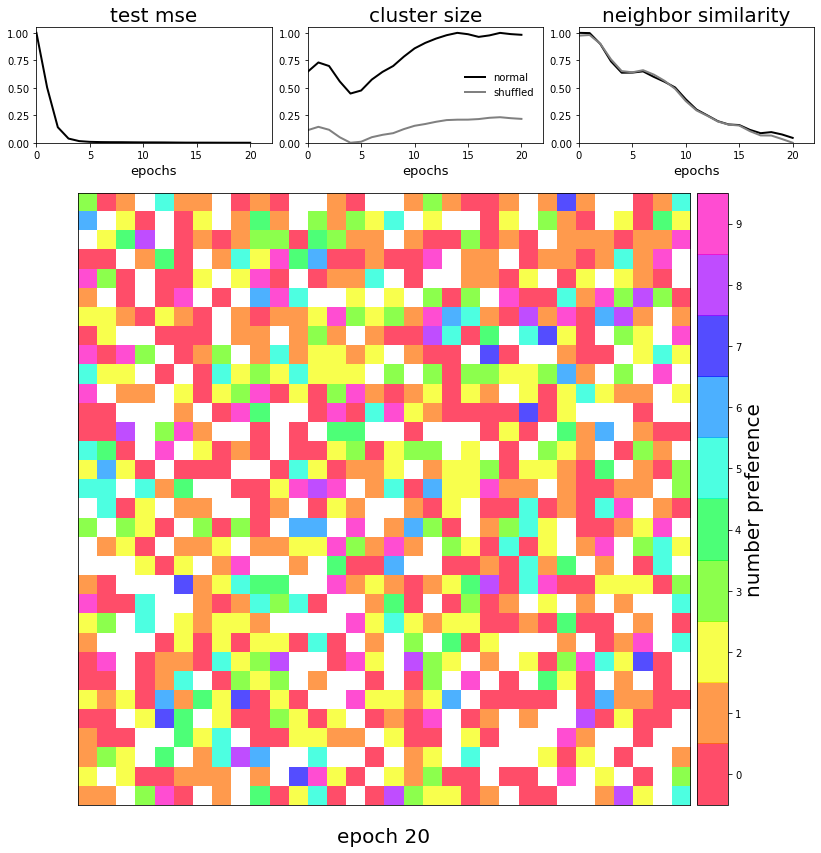

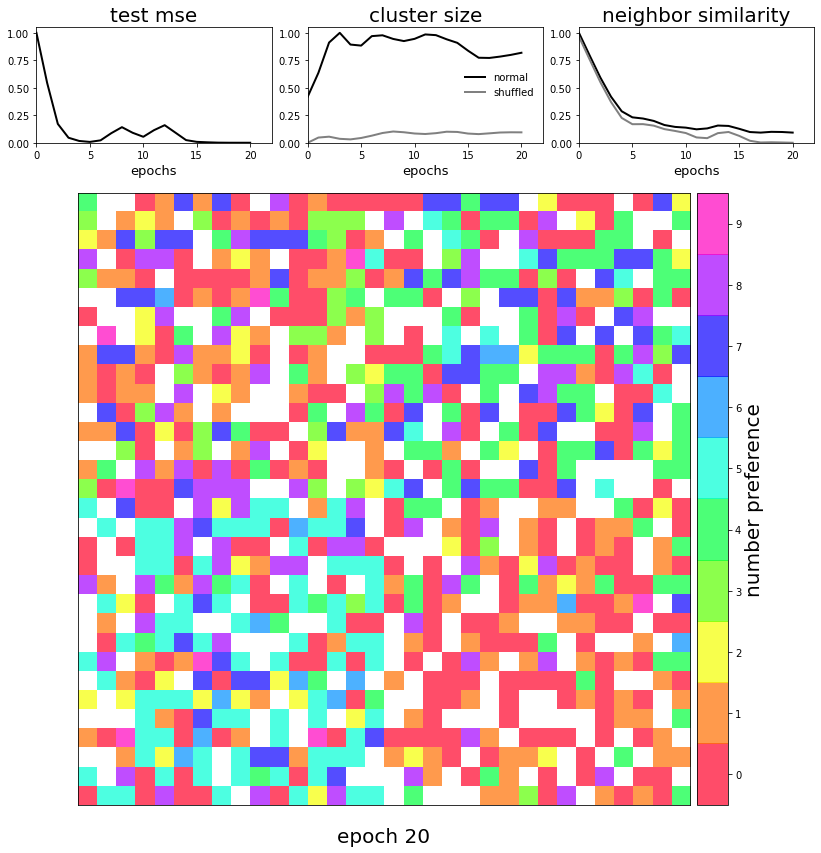

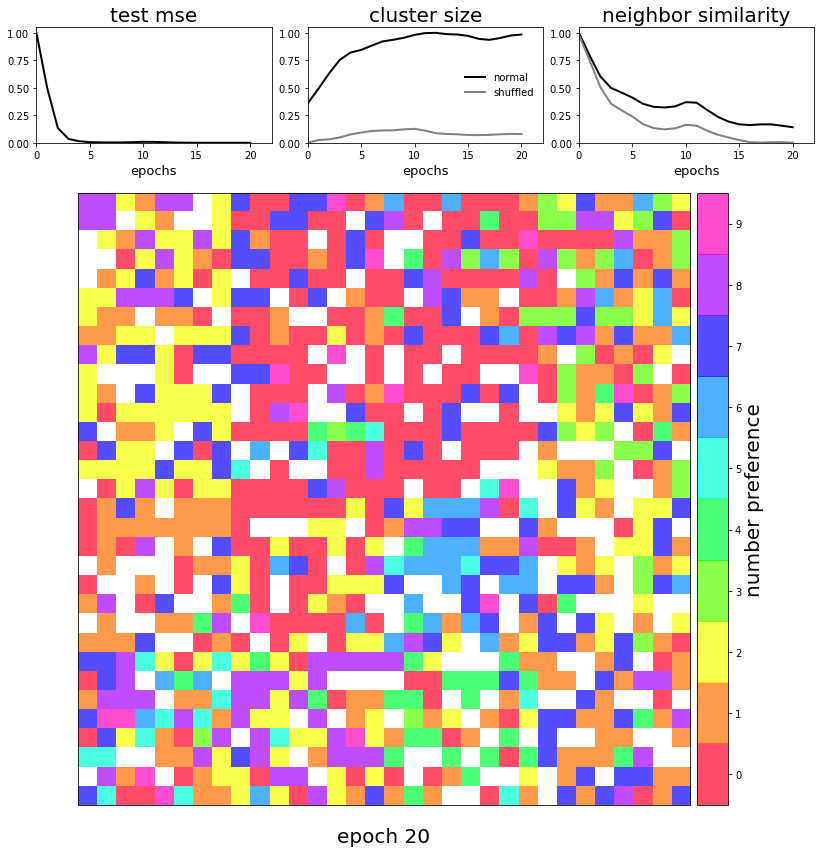

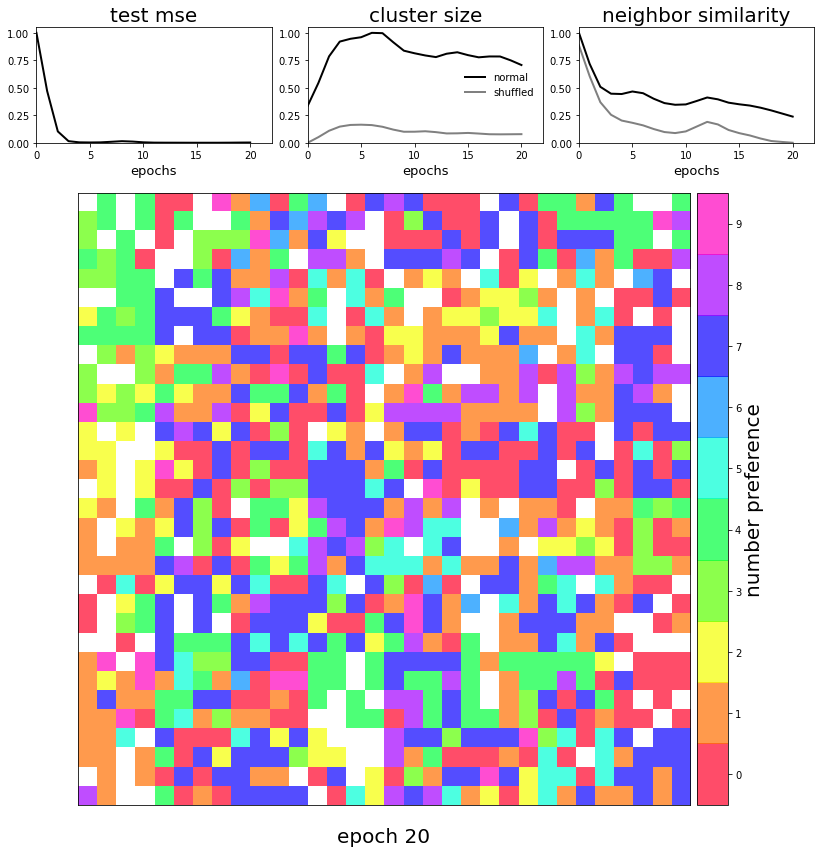

In [ ]:
checkpointpath = '/content/drive/MyDrive/ColabNotebooks/'
modelnames = ['ResetNumber1','ResetNumber2','ResetNumber4','ResetNumber8']
datasets = 4*['Numbers10']

#modelnames = ['ResetNumber1']
#datasets = ['Numbers10']
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'];lc=len(classes)
threshold = 2
smoothing = 0
map_smoothing = 0.
nopref = True
for i, (modelname, dataset) in enumerate(zip(modelnames, datasets)): 
  compute_save_metrics2(modelname=modelname, dataset=dataset, T=threshold, S=smoothing, nopref=nopref)
  animate_numerosity(T=threshold, S_map = map_smoothing, nopref=nopref)


# Conclusions

Is there topography for numbers ? <br>
Yes. In these networks:<br>
1. Units with the same number preference are more likely than chance to be connected on the map (quantified with clustering index).<br>
2. Units with similar number preferences cluster together on the map (quantified with topography index).<br>
3. Clustering increases with the number of subnetworks. Subnetworks appear to specialize in different numbers.